# SPAD-FFS yellow-green beads Bright-Eyes TTM

In [1]:
import numpy as np
from readBHspc import *
import matplotlib.pyplot as plt
from fitPowerLaw import fitPowerLaw
from filterAP import *
from arrivalTimes2TimeTrace import arrivalTimes2TimeTraceBH
from FCS2Corr import *
from arrivalTimes2FilteredTimeTrace import *
from scipy.signal import savgol_filter
from FCSfit import *
from meas_to_count import *
import pandas as pd
from FCS2ArrivalTimes import aTimesData
import math
from corr2csv import corr2csv
from FCSLoadG import FCSLoadG
from listFiles import listFiles
import h5py
from loadATimesData import *
from aTimes2Corr import *
from aTimes2CorrParallel import aTimes2CorrsParallel
from movingAverage import movingAverage
from alignLifetimeHist import alignLifetimeHist
from fitData import fitAndPlot
from plotAiry import *
from findNearest import findNearest
from StokesEinstein import StokesEinstein
import plotColors
from plotPyCorrFit import plotPyCorrFit

C:\ProgramData\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)


## Import data YG beads

.h5 file name

In [2]:
fname = "03_np20nm_cooled15_lp60_224s_10us_40mhz_cirFCS_data-1616679751058692-raw.h5"

Load data, channels = number of channels to load, typically 21

In [4]:
data=loadATimesData(fname, channels=20)

100%|██████████| 20/20 [01:36<00:00,  4.85s/it]


Loading channel 0
Loading channel 1
Loading channel 2
Loading channel 3
Loading channel 4
Loading channel 5
Loading channel 6
Loading channel 7
Loading channel 8
Loading channel 9
Loading channel 10
Loading channel 11
Loading channel 12
Loading channel 13
Loading channel 14
Loading channel 15
Loading channel 16
Loading channel 17
Loading channel 18
Loading channel 19


As an example, show the data array for channel 0. The first column shows for each photon the macrotimes, the second the microtimes. Expressed in ps.

In [5]:
data.det0

array([[ 1.71838566e+12,  1.86777349e+04],
       [ 1.71858367e+12,  1.23755847e+04],
       [ 1.71892631e+12, -4.04401122e+02],
       ...,
       [ 2.25874855e+14,  2.01851962e+04],
       [ 2.25875458e+14,  2.21991179e+04],
       [ 2.25876065e+14,  1.59334478e+04]])

Macrotimes and microtimes are expressed in ps.

In [6]:
data.macrotime = 1e-12
data.microtime = 1e-12

Plot parameters

In [7]:
fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['mathtext.rm'] = 'Arial'
lineW = 1

## Plot intensity traces

Measurement duration: 226 s


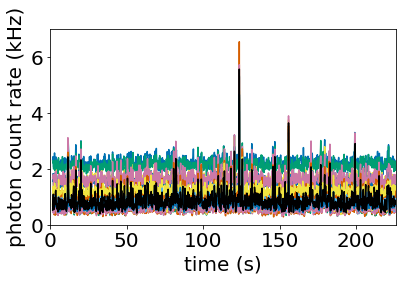

In [8]:
Ndet = 20 # number of channels to plot
totTime = data.macrotime * np.max(data.det10[:,0])
print("Measurement duration: " + '{:.0f}'.format(totTime) + " s")

# plot intensity trace
Lseg = 0.2
maxseg = int(np.floor(totTime / Lseg))

plt.figure()
for det in range(Ndet):
    if det != 10:
        time = getattr(data, "det" + str(det))[:,0]
        timeAbs = time * data.macrotime
        [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
        plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3)

# detector 10
time = getattr(data, "det10")[:,0]
timeAbs = time * data.macrotime
[Itrace, timeBins] = np.histogram(timeAbs, maxseg)
plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3, color='black')
#plt.plot(1e-3*lifetimeBins, histD[:,1], linewidth=lineW*2)
plt.xlabel("time (s)")
output = plt.ylabel("photon count rate (kHz)")
plt.axis([0, 226, 0, 7])
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
# plt.savefig('FLFS_time_traces.svg')

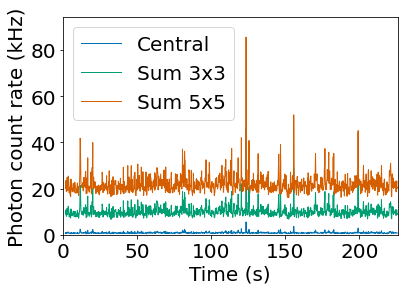

In [9]:
plt.figure()

# central element
timeAbs = getattr(data, "det10")[:,0] * data.macrotime
[Itrace, timeBins] = np.histogram(timeAbs, maxseg)
plt.plot(timeBins[0:-1], Itrace[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

# sum3x3 (4, 5, 6, 9, 10, 11, 14, 15, 16)
ItraceTot = Itrace * 0
for det in [4, 5, 6, 9, 10, 11, 14, 15, 16]:
    timeAbs = getattr(data, "det" + str(det))[:,0] * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    ItraceTot += Itrace
plt.plot(timeBins[0:-1], ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

# sum5x5
ItraceTot = Itrace * 0
for det in range(20):
    timeAbs = getattr(data, "det" + str(det))[:,0] * data.macrotime
    [Itrace, timeBins] = np.histogram(timeAbs, maxseg)
    ItraceTot += Itrace
plt.plot(timeBins[0:-1], ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3, linewidth=lineW)

plt.xlabel("Time (s)")
plt.axis([0, timeBins[-1], 0, 1.1*np.max(ItraceTot[0:] / (timeBins[2] - timeBins[1]) / 1e3)])
output = plt.ylabel("Photon count rate (kHz)")
plt.legend(['Central', 'Sum 3x3', 'Sum 5x5'])
#plt.savefig('FLFS_time_traces.eps', bbox_inches='tight')

## Plot fingerprint pattern

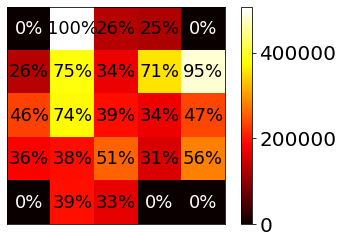

In [10]:
dummy = plotAiry(data)

## Plot lifetime histograms

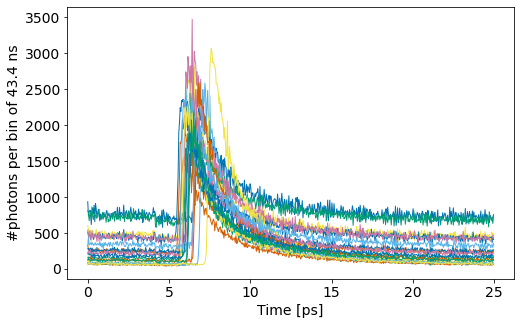

In [13]:
MM = 576
laserF = 40e6 # laser frequency (Hz)
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(8,5))
for det in range(Ndet):
    macroTime = getattr(data, "det" + str(det))[:,0] # ps
    microTime = getattr(data, "det" + str(det))[:,1]
    microTime = np.mod(microTime, 1e12 / laserF)
    microTime = -microTime + np.max(microTime)
    [Ihist, lifetimeBins] = np.histogram(microTime, MM)
    lifetimeBins = lifetimeBins[0:-1] * data.microtime * 1e12
    setattr(data, "hist" + str(det), np.transpose(np.stack((lifetimeBins, Ihist))))
    setattr(data, "det" + str(det), np.transpose([macroTime, microTime]))
    lifetimeBinsN = (lifetimeBins - lifetimeBins[0]) / lifetimeBins[1]
    plt.plot(1e-3*lifetimeBins, Ihist, linewidth=lineW)

data.microbintime = 1e-12 * lifetimeBins[1] # s
plt.xlabel("Time [ps]")
output = plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ns")

## Align lifetime histograms

In [14]:
data = alignLifetimeHist(data)

In [15]:
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1

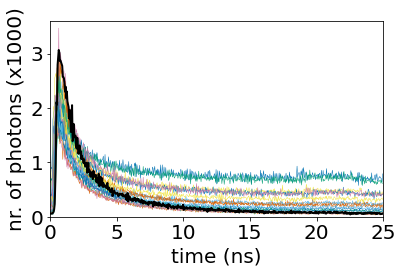

In [16]:
plt.figure()
#plt.margins(0,0)
for det in range(Ndet):
    histD = getattr(data, "Ahist" + str(det))
    if det != 10:
        plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=0.5)

histD = getattr(data, "Ahist" + str(10))
plt.plot(1e-3*lifetimeBins, histD[:,1]/1000, linewidth=lineW*2, color='black')
        

plt.xlabel("time (ns)")
plt.axis([0, 25, 0, 3600/1000])
output = plt.ylabel("nr. of photons (x1000)") # of 43.4 ps
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig('FLFS_histograms.svg')

## Crop first and last part of microtime histograms to calculate lifetimes and filter functions

In [17]:
# find index peak and zoom
Tmax = 210 # 210
fitRange = np.zeros((Ndet, 2), dtype='int')
for det in range(Ndet):
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    idxStart = np.where(Ihist == np.max(Ihist))[0][0] + 1
    idxStop = np.where(Ihist[Tmax:] == np.min(Ihist[Tmax:]))[0][0] + Tmax + 1
    idxStop = np.minimum(idxStop, len(Ihist) - 1)
    fitRange[det, :] = [idxStart, idxStop]
    T = idxStop - idxStart
    # print("T = " + str(T))
data.fitRange = fitRange

findfont: Font family ['DejaVu Sans Display'] not found. Falling back to DejaVu Sans.


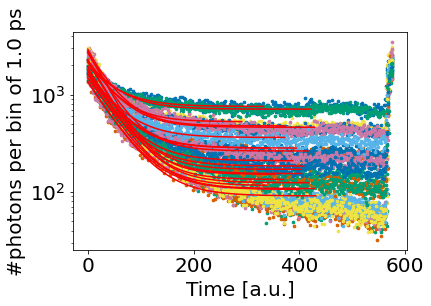

In [18]:
fitresults = np.zeros((Ndet, 3))

plt.figure()
for det in range(Ndet):
    # get histogram detector element i
    IhistSingle = getattr(data, "hist" + str(det)) # number of photons per bin of 43.4 ps as a function of time in ps
    Ihist = IhistSingle[:, 1]
    lifetimeBins = IhistSingle[:, 0]
    binTime = lifetimeBins[1]
    lifetimeBins /= binTime # bin numbers
    
    [idxStart, idxStop] = data.fitRange[det, :]
    fitRangeL = idxStop - idxStart
    
    Ihist = np.roll(Ihist, -idxStart)
    #lifetimeBins = np.roll(lifetimeBins, -idxStart)
    
    lifetimeBinsFit = (lifetimeBins[0:fitRangeL])
    IhistFit = Ihist[0:fitRangeL]
    
    plt.scatter(lifetimeBins, Ihist, s=7)
    plt.xlabel("Time [a.u.]")
    plt.ylabel("#photons per bin of " + '{:.1f}'.format(lifetimeBins[1]) + " ps")
    #plt.xlim([0, lifetimeBinsFit[-1]])

    # fit exponential
    
    fitresult = fitPowerLaw(IhistFit, lifetimeBinsFit, 'exp', [1, 1, 1], [60000, 4, 100], [0, 0, -1e4], [1e6, 20, 1e6])
    A      = fitresult.x[0]
    alpha  = fitresult.x[1]
    B      = fitresult.x[2]
    plt.plot(lifetimeBinsFit, A * np.exp(-alpha * lifetimeBinsFit) + B, color='r')
    plt.yscale('log')
    
    fitresults[det, :] = [A, alpha, B]
    # output = plt.title("A = " + '{:.0f}'.format(A) + "  -  tau = " + '{:.3f}'.format(1/alpha) + "  -  B = " + '{:.5f}'.format(B/A))

In [19]:
print("lifetime = (" + '{:.2f}'.format(np.mean(1e9*data.microbintime/fitresults[:, 1])) + " +/- " + '{:.2f}'.format(np.std(1e9*data.microbintime/fitresults[:, 1])) + ") ns")

lifetime = (1.95 +/- 0.12) ns


In [20]:
[idxStart, idxStop]

[151, 556]

## Calculate filter functions

### Theoretical filter assuming monoexponential decay + offset

In [21]:
data.fitRange

array([[165, 498],
       [149, 487],
       [141, 573],
       [161, 561],
       [149, 441],
       [167, 538],
       [136, 565],
       [146, 569],
       [138, 479],
       [149, 523],
       [176, 531],
       [140, 558],
       [151, 546],
       [149, 558],
       [160, 563],
       [143, 560],
       [145, 574],
       [161, 534],
       [148, 536],
       [151, 556]])

In [22]:
data.fitRange[:,1] = 400

In [23]:
A = fitresults[:, 0]
alpha = fitresults[:, 1]
B = fitresults[:, 2]

C:\Users\eslenders\OneDrive - Fondazione Istituto Italiano Tecnologia\Python\FCS\filterAP.py:57: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


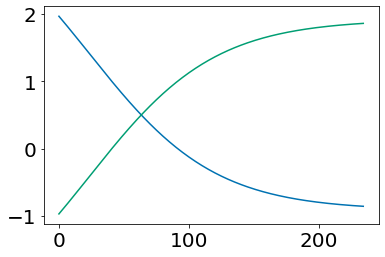

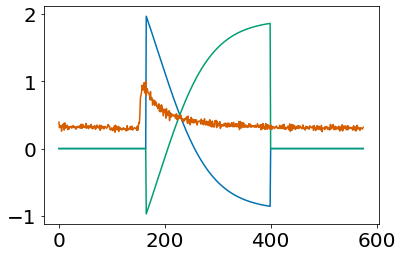

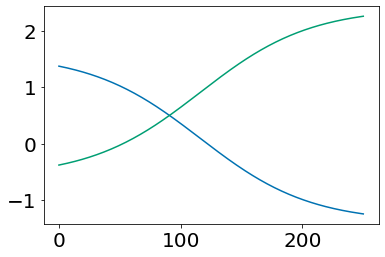

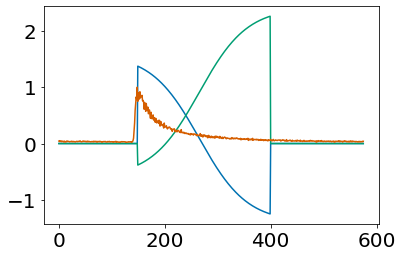

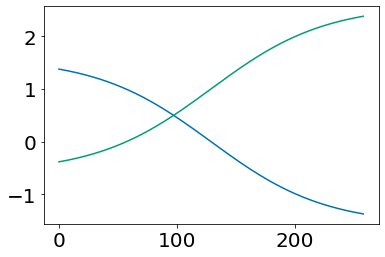

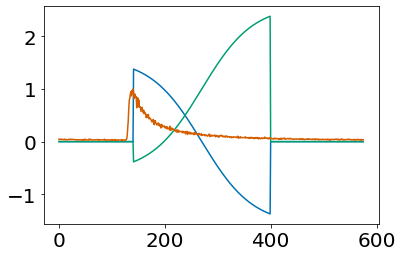

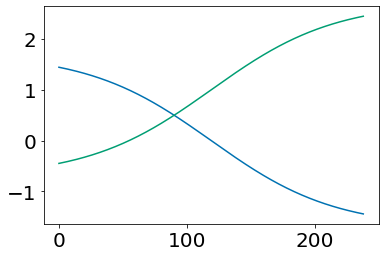

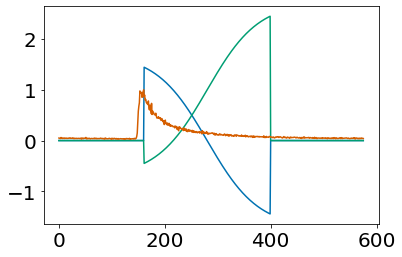

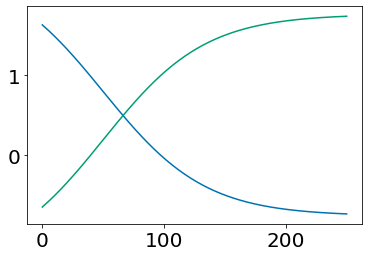

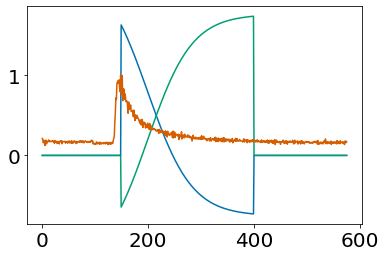

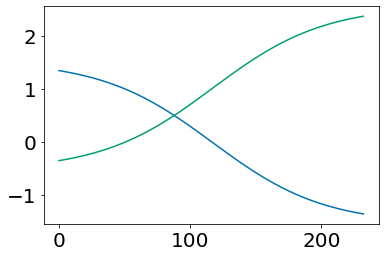

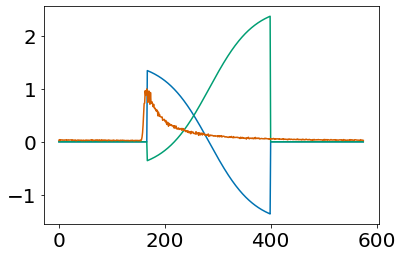

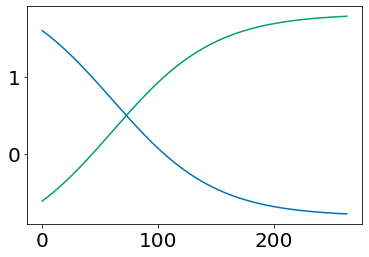

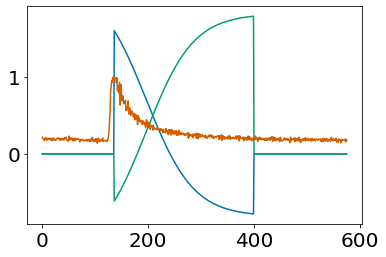

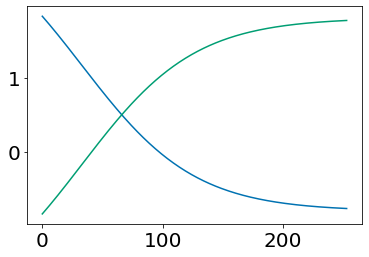

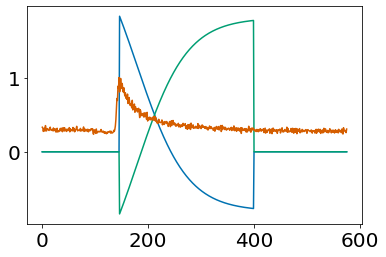

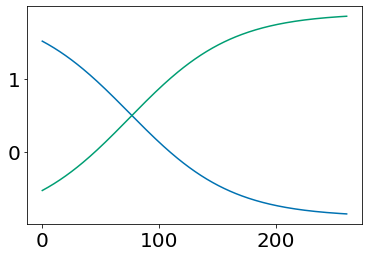

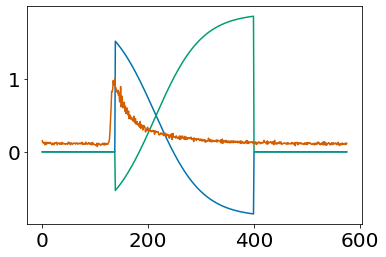

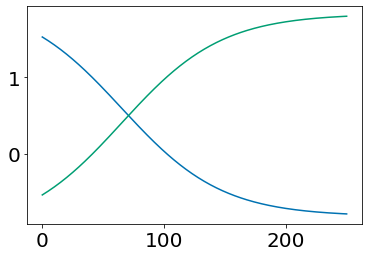

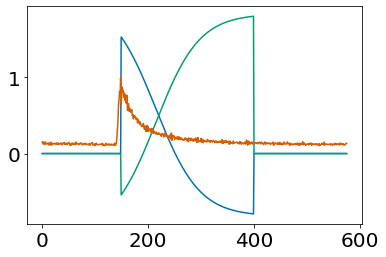

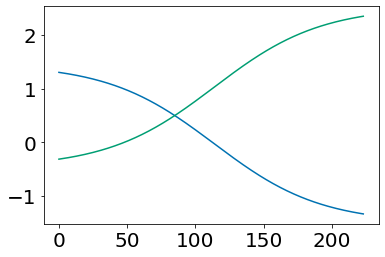

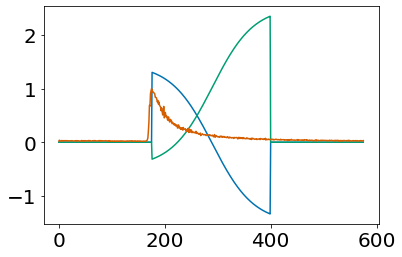

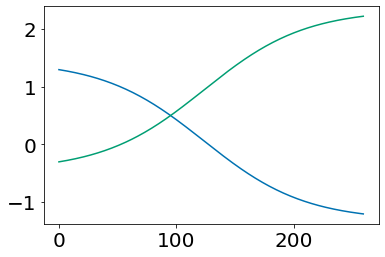

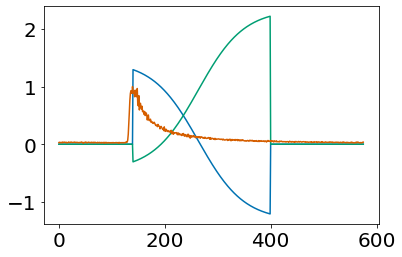

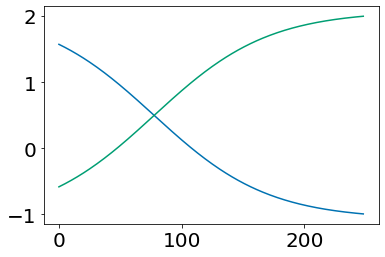

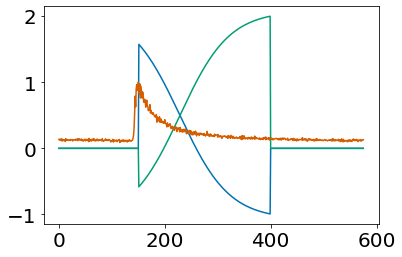

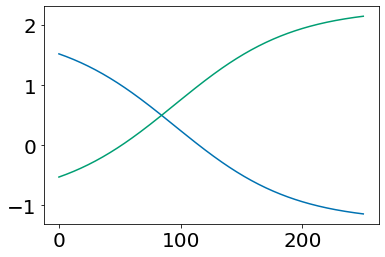

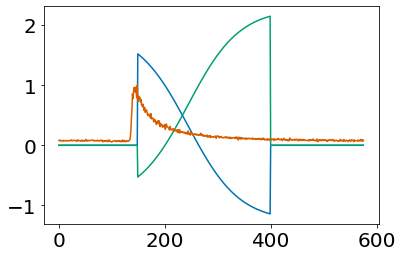

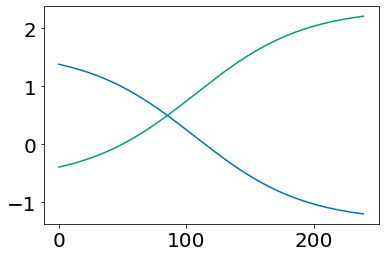

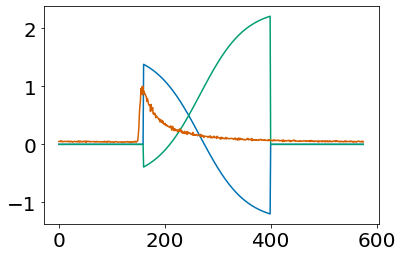

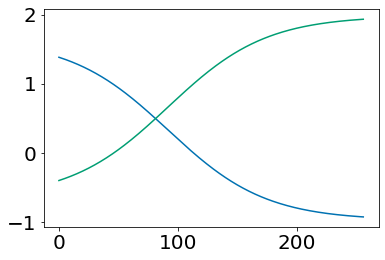

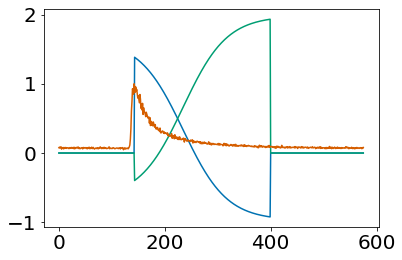

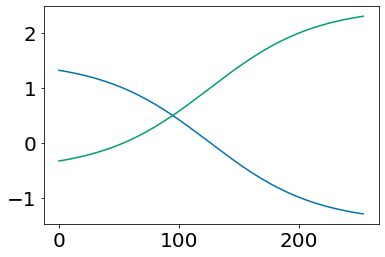

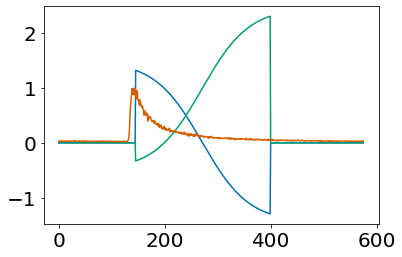

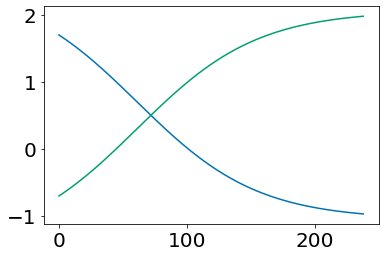

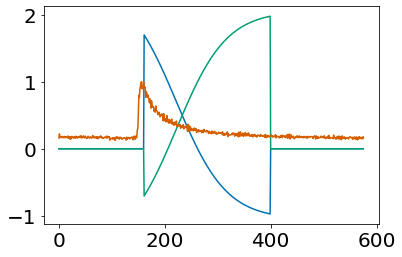

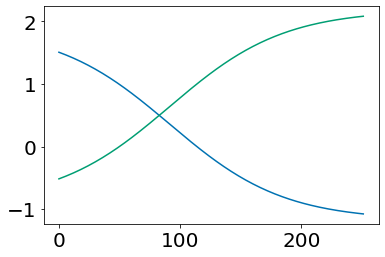

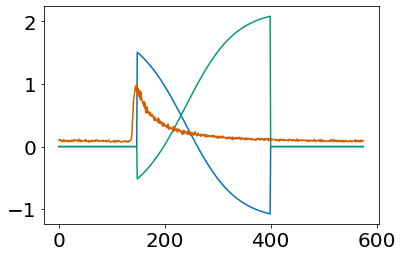

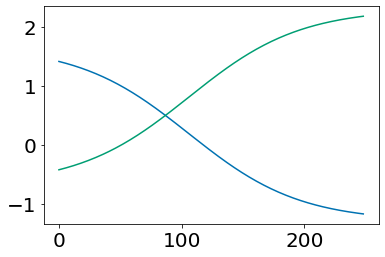

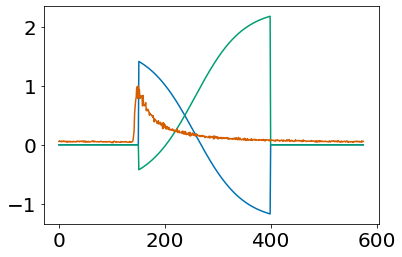

In [24]:
# filtersTheo contains all filters [det element, filtervalues, filter number]
filtersTheo = np.zeros((Ndet, len(Ihist), 2))
for det in range(Ndet):
    # calculate filter 
    tau = 1 / alpha[det]
    T = int(np.diff(data.fitRange[det, :]))
    offset = B[det] / A[det] # relative offset, wrt amplitude
    Ftheo = filterAP(0, tau, T, offset, False)
    
    # pad zeros before and after filter domain
    [startIdx, stopIdx] = data.fitRange[det, :]
    filtersTheo[det, startIdx:stopIdx, :] = np.transpose(Ftheo)
    
    # figure
    histSingle = getattr(data, 'hist' + str(det))
    histSingle[:,1] /= np.max(histSingle[:,1])
    plt.figure()
    plt.plot(filtersTheo[det, :, 0])
    plt.plot(filtersTheo[det, :, 1])
    plt.plot(histSingle[:,1])

In [25]:
lifetimeBins *= binTime

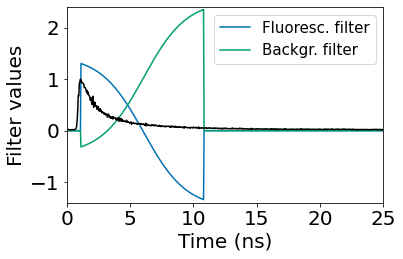

In [26]:
histSingle = getattr(data, 'hist' + str(10))
histSingle[:,1] /= np.max(histSingle[:,1])

plt.figure()
roll = -150
plt.plot(1e-3*lifetimeBins, np.roll(filtersTheo[10, :, 0], roll), label='Fluoresc. filter')
plt.plot(1e-3*lifetimeBins, np.roll(filtersTheo[10, :, 1], roll), label='Backgr. filter')
plt.plot(1e-3*lifetimeBins, np.roll(histSingle[:,1], roll), color='black')
plt.legend(fontsize=15)
plt.xlabel("Time (ns)")
plt.ylabel('Filter values')
plt.axis([0, 25, -1.4, 2.4])
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.savefig('FLFS_filters.svg', bbox_inches='tight')

### Filter using theoretical filter functions

In [27]:
data = aTimesFiltered(data, filtersTheo, False)

Calculating filtered photon streams det0
Calculating filtered photon streams det1
Calculating filtered photon streams det2
Calculating filtered photon streams det3
Calculating filtered photon streams det4
Calculating filtered photon streams det5
Calculating filtered photon streams det6
Calculating filtered photon streams det7
Calculating filtered photon streams det8
Calculating filtered photon streams det9
Calculating filtered photon streams det10
Calculating filtered photon streams det11
Calculating filtered photon streams det12
Calculating filtered photon streams det13
Calculating filtered photon streams det14
Calculating filtered photon streams det15
Calculating filtered photon streams det16
Calculating filtered photon streams det17
Calculating filtered photon streams det18
Calculating filtered photon streams det19


In [28]:
G = aTimes2CorrsParallel(data, [10, 'sum3', 'sum5'], accuracy=100, taumax=1/data.macrotime, split=10)

Calculating correlation 10
   Filter 0
   Filter 1
   Filter 2
Calculating correlation sum3
Extracting and sorting photons
   Filter 0
   Filter 1
   Filter 2
Calculating correlation sum5
Extracting and sorting photons
   Filter 0
   Filter 1
   Filter 2


Store correlations to .csv files

In [29]:
# corr2csv(G, fname[0:-3], limits=[0, 0], chunks=0)

Load correlations from .csv files

In [4]:
G = FCSLoadG(fname[0:-3] + '_', folderName="", printFileNames=True)

det10F0_average
det10F1_average
det10F2_average
sum3F0_average
sum3F1_average
sum3F2_average
sum5F0_average
sum5F1_average
sum5F2_average
--------------------------
9 files found.
--------------------------


## Plot correlations

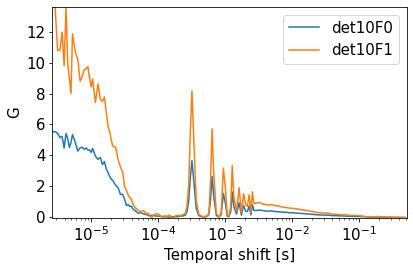

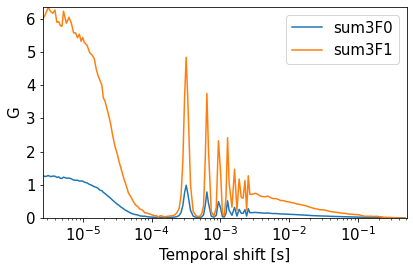

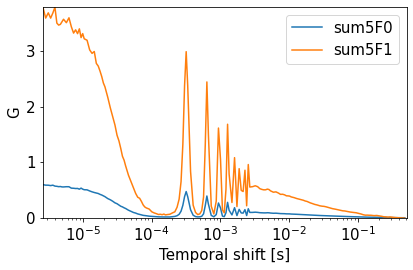

In [34]:
start = 180
stop = -10
h = plotFCScorrelations(G, ['det10F0_average', 'det10F1_average'], limits=[start, stop], pColors=[0, 1, 2])
h = plotFCScorrelations(G, ['sum3F0_average', 'sum3F1_average'], limits=[start, stop], pColors=[0, 1, 2])
h = plotFCScorrelations(G, ['sum5F0_average', 'sum5F1_average'], limits=[start, stop], pColors=[0, 1, 2])

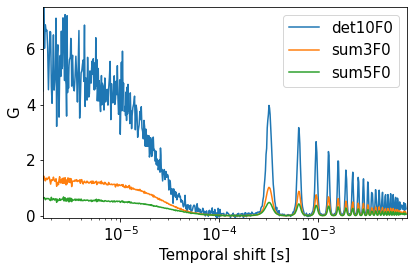

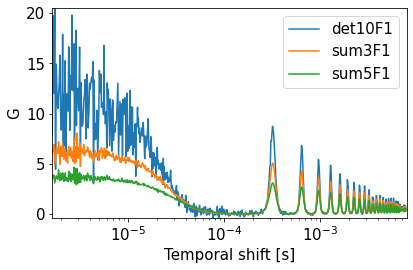

In [6]:
h = plotFCScorrelations(G, ['det10F0_average', 'sum3F0_average', 'sum5F0_average'], limits=[start, stop], pColors=[0, 1, 2])
h = plotFCScorrelations(G, ['det10F1_average', 'sum3F1_average', 'sum5F1_average'], limits=[start, stop], pColors=[0, 1, 2])
h = plotFCScorrelations(G, ['det10F2_average', 'sum3F2_average', 'sum5F2_average'], limits=[start, stop], pColors=[0, 1, 2])

## Fit correlations unfiltered data

------
0.009932111871999995
saving figure
tauD = 0.9703316558991911 ms
chi2 = 129.28793172059332
fitresult[0] = 0.18694446526525968
fitresult[1] = 0.9703316558991911
fitresult[2] = 2.3598606160628902e-07
1.4348037841979071e-11
diameter: 2.991486940203513e-08
------
0.009932111871999995
saving figure
tauD = 1.5860699111465075 ms
chi2 = 0.384037041458237
fitresult[0] = 0.7894384004801971
fitresult[1] = 1.5860699111465075
fitresult[2] = 2.9457276069437323e-07
1.3677378079819259e-11
diameter: 3.138172211906376e-08
------
0.009932111871999995
saving figure
tauD = 2.0626789421508467 ms
chi2 = 0.048686219271096835
fitresult[0] = 1.718263579750728
fitresult[1] = 2.0626789421508467
fitresult[2] = 3.4887449133120816e-07
1.475186082215651e-11
diameter: 2.909596852849891e-08


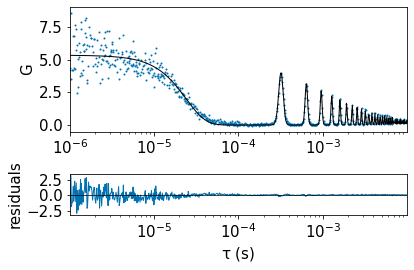

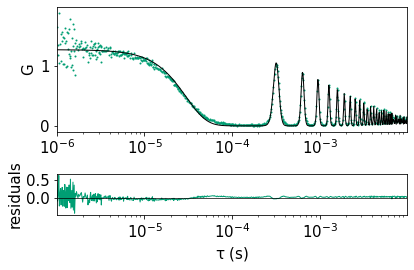

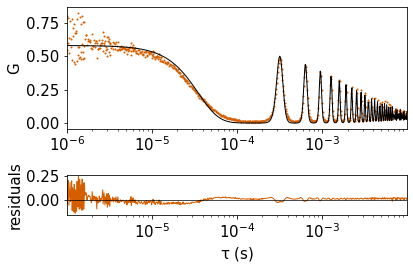

In [7]:
SF = [4.5, 4.1, 4.1] # shape parameter for central, sum3x3, sum5x5
amp = [0.1, 1, 1] # start values for the amplitude of the correlation functions for central, sum3x3, sum5x5
w0 = [141e-9, 184e-9, 218e-9] # start values for the beam waist for central, sum3x3, sum5x5
w0 = [220e-9, 290e-9, 340e-9]
fitresults = np.zeros((3, 3))
colors = ["C0", "C1", "C2"]
Glist = ["det10F0_average", "sum3F0_average", "sum5F0_average"]
color = 0
for k in range(3):
    i = Glist[k]
    dataSingle = getattr(G, i)
    dataSingleF = getattr(G, i)
    tau = dataSingle[:,0]
    Gexp = dataSingle[:,1]
    GexpF = dataSingleF[:,1]
    [dummy, start] = findNearest(tau,1e-6)
    [dummy, stop] = findNearest(tau,1e-2)
    fitarray = np.array([1, 1, 1, 0, 0, 0, 0])
    paramStart = np.array([amp[k], 2.4, 300e-9, SF[k], 0.5e-6, 320e-6, 0])
    paramMin = np.array([0, 5e-6, 100e-9, 3, 0, 0, -1])
    paramMax = np.array([1e6, 10, 10000e-9, 6, 10, 10, 1])
                                #  [N, tauD, w, SF, Rcirc, Tcirc, offset]
    fitresult = FCSfit(Gexp[start:stop],  tau[start:stop], 'fitfunCircFCS', fitarray, paramStart,  paramMin, paramMax, colors[color], 0, savefig=Glist[k]+'.svg', plotTau=False)
    for l in range(sum(fitarray)):
        print("fitresult[" + str(l) + "] = " + str(fitresult.x[l]))
    D = fitresult.x[2]**2 / 4 / (fitresult.x[1]*1e-3)
    print(D)
    print("diameter: " + str(StokesEinstein(D)))
    color += 1
    fitresults[k, :] = fitresult.x

    #savefig=Glist[k]+'.eps'

## Fit correlations filtered data

------
0.009932111871999995
saving figure
tauD = 0.8951454526717223 ms
chi2 = 3792.816098434692
fitresult[0] = 0.08480406902600604
fitresult[1] = 0.8951454526717223
fitresult[2] = 2.2168792710532581e-07
1.3725572999776901e-11
diameter: 3.1271530756875395e-08
------
0.009932111871999995
saving figure
tauD = 1.5079156325370122 ms
chi2 = 1.7137259116167591
fitresult[0] = 0.1613702209354747
fitresult[1] = 1.5079156325370122
fitresult[2] = 2.876335170683698e-07
1.3716457067615397e-11
diameter: 3.129231375875123e-08
------
0.009932111871999995
saving figure
tauD = 1.9852317660500107 ms
chi2 = 0.28726389543437914
fitresult[0] = 0.273409328310807
fitresult[1] = 1.9852317660500107
fitresult[2] = 3.389092886106603e-07
1.4464243907289258e-11
diameter: 2.9674532659253385e-08


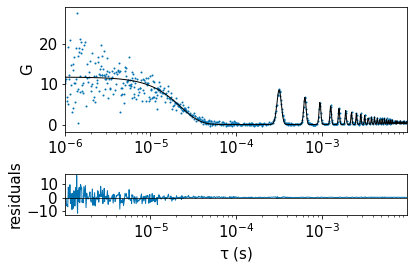

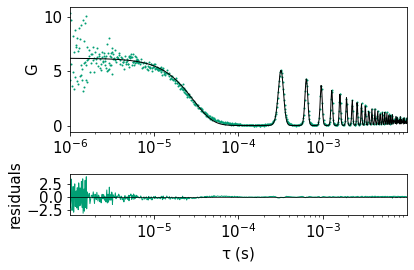

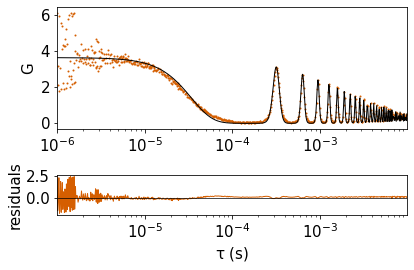

In [9]:
SF = [4.5, 4.1, 4.1]
w0 = [141e-9, 184e-9, 218e-9]
fitresultsF = np.zeros((3, 3))
colors = ["C0", "C1", "C2"]
Glist = ["det10F1_average", "sum3F1_average", "sum5F1_average"]
color = 0
for k in range(3):
    i = Glist[k]
    dataSingle = getattr(G, i)
    dataSingleF = getattr(G, i)
    tau = dataSingle[:,0]
    Gexp = dataSingle[:,1]
    GexpF = dataSingleF[:,1]
    [dummy, start] = findNearest(tau,1e-6)
    [dummy, stop] = findNearest(tau,1e-2)
    fitarray = np.array([1, 1, 1, 0, 0, 0, 0])
    paramStart = np.array([0.1, 1e-3, 300e-9, SF[k], 0.5e-6, 320e-6, 0])
    paramMin = np.array([0, 5e-6, 100e-9, 4, 0, 0, -1])
    paramMax = np.array([1e6, 10, 10000e-9, 5, 10, 10, 1])
                                #  [N, tauD, w, SF, Rcirc, Tcirc, offset]
    fitresult = FCSfit(Gexp[start:stop],  tau[start:stop], 'fitfunCircFCS', fitarray, paramStart,  paramMin, paramMax, colors[color], savefig=Glist[k]+'.svg', plotTau=False)
    for l in range(sum(fitarray)):
        print("fitresult[" + str(l) + "] = " + str(fitresult.x[l]))
    D = fitresult.x[2]**2 / 4 / (fitresult.x[1]*1e-3)
    print(D)
    print("diameter: " + str(StokesEinstein(D)))
    color += 1
    fitresultsF[k, :] = fitresult.x

# savefig=Glist[k]+'.eps'

## Plot diffusion law filtered vs. unfiltered data

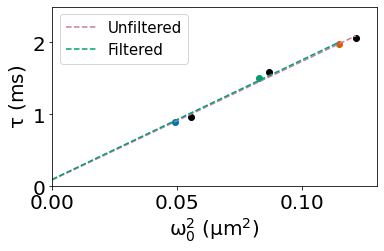

In [10]:
plt.figure()

fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1.5

# UNFILTERED
w2 = 1e12*fitresults[:,2]**2

# linear fit
linfit = np.polyfit(w2, fitresults[:,1], 1)
xfit = np.array([0, np.max(w2)])
yfit = linfit[0] * xfit + linfit[1]
plt.plot(xfit, yfit, '--', color='C3', linewidth=lineW, label='Unfiltered')

for i in range(3):
    plt.scatter(w2[i], fitresults[i,1], color='k')


# FILTERED
w2F = 1e12*fitresultsF[:,2]**2

# linear fit
linfit = np.polyfit(w2F, fitresultsF[:,1], 1)
xfit = np.array([0, np.max(w2F)])
yfit = linfit[0] * xfit + linfit[1]
plt.plot(xfit, yfit, '--', color='C7', linewidth=lineW, label='Filtered')

for i in range(3):
    plt.scatter(w2F[i], fitresultsF[i,1], color='C'+str(i))
    
plt.axis([0, 0.13, 0, 2.5])
plt.xlabel(r'$\omega_0^2$ $(µm^2)$')
plt.ylabel(r'$\tau$ (ms)')
plt.legend(fontsize=15)
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('FLFS_tau_vs_w02.svg')

## Plot N vs. V for unfiltered and filtered data

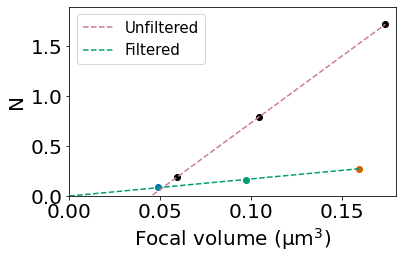

In [11]:
fontSize = 20
plt.rcParams.update({'font.size': fontSize})
plt.style.use("seaborn-colorblind")
lineW = 1.5

plt.figure()

# UNFILTERED
vol = 1e18 * fitresults[:,2]**3 * SF
for i in range(3):
    plt.scatter(vol[i], fitresults[i,0], color='k')

# linear fit
linfit = np.polyfit(vol, fitresults[:,0], 1)
xfit = np.array([0, np.max(vol)])
yfit = linfit[0] * xfit + linfit[1]
plt.plot(xfit, yfit, '--', color='C3', linewidth=lineW, label='Unfiltered')

# FILTERED
volF = 1e18 * fitresultsF[:,2]**3 * SF
for i in range(3):
    plt.scatter(volF[i], fitresultsF[i,0], color="C"+str(i))

plt.axis([0, 0.18, 0, np.max(fitresults[:,0])*1.1])
plt.xlabel(r'$Focal$ $volume$ $(µm^3)$')
plt.ylabel('N')

# linear fit
linfit = np.polyfit(volF, fitresultsF[:,0], 1)
xfit = np.array([0, np.max(volF)])
yfit = linfit[0] * xfit + linfit[1]
plt.plot(xfit, yfit, '--', color='C7', linewidth=lineW, label='Filtered')
plt.legend(fontsize=15)
plt.rcParams['svg.fonttype'] = 'none'
plt.tight_layout()
plt.rcParams['svg.fonttype'] = 'none'
plt.savefig('FLFS_N_vs_w03.svg')